This question is heavily inspired by David H. Montgomery's Pup Inflation post. His analysis is an excellent data science task, and the same question is here: has there been grade inflation on the @dog_rates Twitter, which rates the cuteness of users' dog pictures?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns

In [2]:
rate = pd.read_csv('dog_rates_tweets.csv')
rate.head()

,id,created_at,text
0,862722525377298433,2017-05-11 17:34:13,"b""This is Dave. He passed the h*ck out. It's b..."
1,862698176012320769,2017-05-11 15:57:27,"b""@starstrickenSF @wf_atx @kalesalad Wow I'm u..."
2,862517696700854274,2017-05-11 04:00:18,b'RT @LittleSkyz: Hey everyone Radar needs you...
3,862457590147678208,2017-05-11 00:01:27,"b'This is Jersey. He likes to watch movies, bu..."
4,862418272276361220,2017-05-10 21:25:13,b'RT @zboah: Ok did it work this time https://...


In [3]:
#Find tweets that contain an “n/10” rating (because not all do). Extract the numeric rating. Exclude tweets that don't contain a rating.
new = rate['text'].str.extract('(\d+(\.\d+)?)/10',expand=True)
rate['rating'] = new[0].astype(float)
rate = rate[rate['rating'].notnull()]

In [4]:
#Remove outliers: there are a few obvious ones. Exclude rating values that are too large to make sense. (Maybe larger than 25/10?)
rate = rate.query("rating < 20")

In [5]:
#Make sure the 'created_at' column is a datetime value, not a string. 
rate['created_at'] = pd.to_datetime(rate['created_at'])

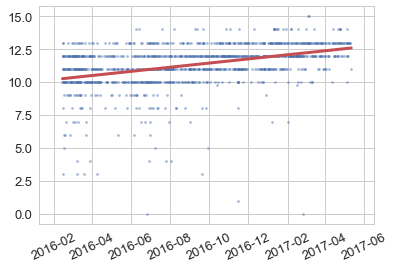

In [6]:
#Create a scatter plot of date vs rating
sns.set(style = 'whitegrid',color_codes=True,font_scale=1.3, rc={"lines.linewidth": 2.5})
plt.xticks(rotation=25)
plt.scatter(rate['created_at'].values, rate['rating'].values, c='b',alpha=0.5, s=5)
rate['timestamp'] = rate['created_at'].apply(lambda x:x.timestamp())
fit = slope , intercept, r_value, p_value, slope_std_error = stats.linregress(rate['timestamp'], rate['rating'])
plt.plot(rate['created_at'].values, rate['timestamp']*fit.slope + fit.intercept, 'r-',linewidth=3)
plt.show()


From the scatter plot, I noticed that there are a lot of points closing to 11, so I
want to figure out the change of rate ranges, which are 0-9, 10-12 and over 13. I
grouped the year/month and rate range together, then took the sum of the number of
rate according to the rateRange classifier. The histogram(stacked bar chart) can
present the portion of these three ranges clearly, and we can get a clear output that
the large number of rate ranges is 10-12. Meanwhile, there are less bad dogs (0-9)
since the 0-9 part almost disappear.

In [7]:
#Create rate range
def rateSplit(rate):
    if rate < 10:
        rate = "[0,10)"
    elif rate >=10 and rate <= 12:
        rate = "[10-12]"
    elif rate >= 13:
        rate = "(12,∞)"
    return rate

rate['rateRange'] = rate['rating'].apply(lambda x: rateSplit(x))
rate['rateRange'].head()

0     [10-12]
8      (12,∞)
9      (12,∞)
20     (12,∞)
30    [10-12]
Name: rateRange, dtype: object

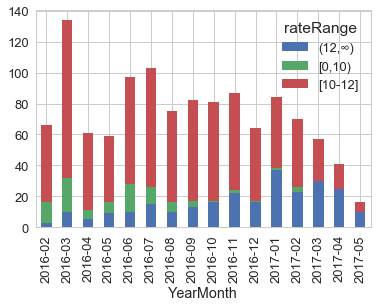

In [8]:
rate['YearMonth'] = rate['created_at'].apply(lambda x:x.strftime('%Y-%m'))
# rate2 = rate.groupby(['YearMonth' , 'rateRange'])['rateRange'].count()
#### VERY VERY USEFUL WAY FOR STACKED BAR CHART !!! ####
rate2 = rate.groupby(['YearMonth' , 'rateRange'])['rateRange'].count().unstack()
# rate2 = rate.groupby(['YearMonth'])['rateRange'].count()
rate2.plot(kind='bar', stacked = True)
plt.show()

However, the fact might be different from the rate showing at @dog_rate
because bad dogs should not disappear because we can still hear the news that so
dogs bite people. This is a contradiction comparing with the reality. The reason
leading to the rate inflation is that people who post their dog to @dog_rate must
have an either cute dog or funny dog. Those people can’t accept a low score of their
dogs, so that they almost choose the best photo of their dogs that everyone likes. On
the other hand, it is a promotion for @dog_rate to gain fans. @dog_rate can catch the
humanity, so that most of his rates are over 10, which is the full rate that can’t be
exceed. Thus, it is not weird that pup inflation truly occurs in @dog_rate.

In [9]:
x = rate['timestamp']
y = rate['rating']
# X = sm.add_constant(x)
result = sm.OLS(y, x).fit()
print(result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 5.455e+04
Date:                Sat, 14 Jul 2018   Prob (F-statistic):               0.00
Time:                        18:23:54   Log-Likelihood:                -2266.6
No. Observations:                1177   AIC:                             4535.
Df Residuals:                    1176   BIC:                             4540.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
timestamp   7.676e-09   3.29e-11    233.561      0.0

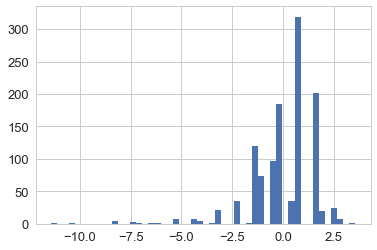

In [10]:
plt.hist(result.resid, bins=50)
plt.show()